## Collaborative filtering using Non-Negative Matrix Factorization (NMF)

In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import norm, solve
import time
import matplotlib.pyplot as plt
import math

### Download the Movielens Dataset

In [2]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip # if you dont have unzip: apt-get install unzip
# !cd ml-100k/ml-100k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  4957k      0 --:--:-- --:--:-- --:--:-- 4952k
Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Create the Ratings Matrix

In [3]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(r"./ml-100k/ml-100k/u.data", sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


We see that there are 943 users and 1682 items

In [4]:
ratings_matrix = np.empty((df.user_id.nunique(), df.item_id.nunique())).astype(np.float32)
for row in df.index:
    ratings_matrix[df.iloc[row].user_id-1, df.iloc[row].item_id-1] = df.iloc[row].rating
print ('number of users = {}'.format(df.user_id.nunique()))
print ('number of items = {}'.format(df.item_id.nunique()))

number of users = 943
number of items = 1682


We see that the dataset contains many empty entries

In [5]:
zeroentries = (1-np.count_nonzero(ratings_matrix) /(ratings_matrix.shape[0]*ratings_matrix.shape[1]))*100
print ('Zero entries = {:4.2f}%'.format(zeroentries))

Zero entries = 93.70%


We see that most of the entries in the ratings matrices are zeros

### We develop a simple class for performing ALS

Our objective is to find $W$ and $H$ such that,
$$ R \approx WH$$
where $R$ is the ratings matrix and $W$, and $H$ are the latent factor matrices for users and items respectively.

We follow [1], and use the following multiplicative update rule:
$$ H_{a \mu} = H_{a \mu} \frac{(W^{T} R)_{a \mu}} {(W^{T} W H)_{a \mu}}$$
and,
$$ W_{ia} =  W_{ia} \frac{(RH^{T})_{ia}}{(WHH^{T})_{ia}} $$

This minimizes the Eucledian distance, $||R - WH||$. Strictly speaking, under this update rule the Eucledian distance is non-increasing. We can also employ another multiplicate update rule under which KL divergence (i.e. $D(R || WH)$ is non-increasing.


[1] Lee, Daniel D., and H. Sebastian Seung. "Algorithms for non-negative matrix factorization." Advances in neural information processing systems. 2001


In [44]:
class NMF:
    
    def __init__(self):
        """
            description: a simple class for performing
                         matrix factorization using NMF
        """
        self.n_factors = 0 # number of latent factors


    def set_factors(self, n_factors):
        """
            description: sets the number of latent factors
        """
        self.n_factors = n_factors
        return self

    def set_initial_factor_matrices(self, nusers, nitems):
        """
            description: sets the initial latent-factor matrices
        """
        self.W = np.random.random((nusers, self.n_factors)).astype(np.float32)
        self.H = np.random.random((self.n_factors, nitems)).astype(np.float32)
        return self
        
    def get_n_factors(self):
        """
            description: gets the number of latent factors
        """
        return self.n_factors
   
    
    def get_factor_matrices(self):
        """
            description: gets user and item latent
                         factor matrices
        """
        return self.W, self.H
    
    def get_loss(self, R):
        """
            description: gets the MSE loss
        """
        return norm(R - np.matmul(self.W, self.H))
    
    
    def update(self, R):
        """
            description: updates matrices W, H
        """
        # update H
        nr = np.matmul(self.W.T, R) 
        dr = np.matmul(np.matmul(self.W.T, self.W), self.H) 
        self.H = self.H * np.divide (nr, dr)
        
        #update W
        nr = np.matmul(R, self.H.T)
        dr = np.matmul(np.matmul(self.W, self.H), self.H.T)
        self.W = self.W * np.divide (nr, dr)
        
    

In [45]:
# number of latent factors
n_factors = 40

# construct the NMF object
nmf = NMF().set_factors(n_factors)\
           .set_initial_factor_matrices(ratings_matrix.shape[0], ratings_matrix.shape[1])

#set epochs
epochs = 1000
W_norm = []
H_norm = []
L = []

# training
W, H = nmf.get_factor_matrices()
t0 = time.time()

for i in range(epochs):
 
    # update W, H
    nmf.update(ratings_matrix)
    
    W_new, H_new = nmf.get_factor_matrices()
    
    # gather stats for loss
    L.append(nmf.get_loss(ratings_matrix))
    W_norm.append(norm((W_new - W)))
    H_norm.append(norm((H_new - H)))
    
    W, H = W_new, H_new

print("Time taken for the run = {:5.2f} s".format(time.time()-t0))

Time taken for the run = 9504.56 s


### We plot the MSE loss function as well the convergence of factor matrices (W, H)

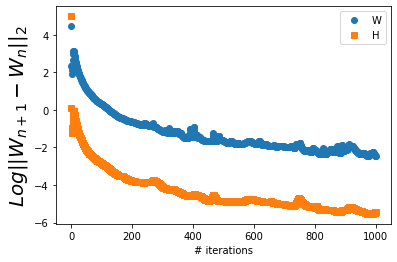

In [64]:
plt.plot(np.log(W_norm), 'o', np.log(H_norm),'s')
plt.xlabel('# iterations')
plt.ylabel('$Log ||W_{n+1} - W_{n}||_{2}$', fontsize=20)
plt.legend(['W','H'])
plt.show()

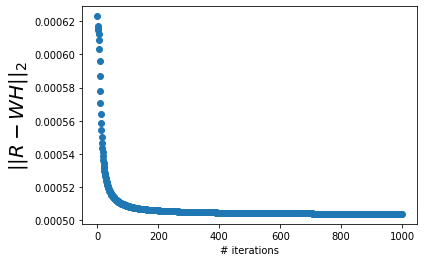

In [61]:
mseL = np.array(L)/(ratings_matrix.shape[0]*ratings_matrix.shape[1])
plt.plot(mseL, 'o')
plt.xlabel('# iterations')
plt.ylabel('$||R - WH||_{2}$', fontsize=20)
plt.show()

## 